In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import missingno as msno
from collections import Counter
from itertools import chain, combinations
import sklearn as sk
from sklearn.decomposition import PCA

# Data exploration

In [2]:
data = pd.read_csv("newdata3.csv", engine='python').drop(['Unnamed: 0'], axis = 1)
data.info()
#no duplicates
#data = data.drop_duplicates(subset = ['weight_16', 'height_16'])
#data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13734 entries, 0 to 13733
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   weight_16          5351 non-null   float64
 1   height_16          5364 non-null   float64
 2   iq                 7288 non-null   float64
 3   dep_band_15        5299 non-null   float64
 4   anx_band_15        5303 non-null   float64
 5   exercise           4971 non-null   float64
 6   child_bull         4989 non-null   float64
 7   has_dep_diag       4513 non-null   float64
 8   secd_diag          4513 non-null   float64
 9   prim_diag          4513 non-null   float64
 10  panic_score        4513 non-null   float64
 11  dep_thoughts       1805 non-null   float64
 12  dep_score          4513 non-null   float64
 13  comp_house         13734 non-null  float64
 14  alon               4837 non-null   float64
 15  draw               4827 non-null   float64
 16  musi               481

<AxesSubplot:>

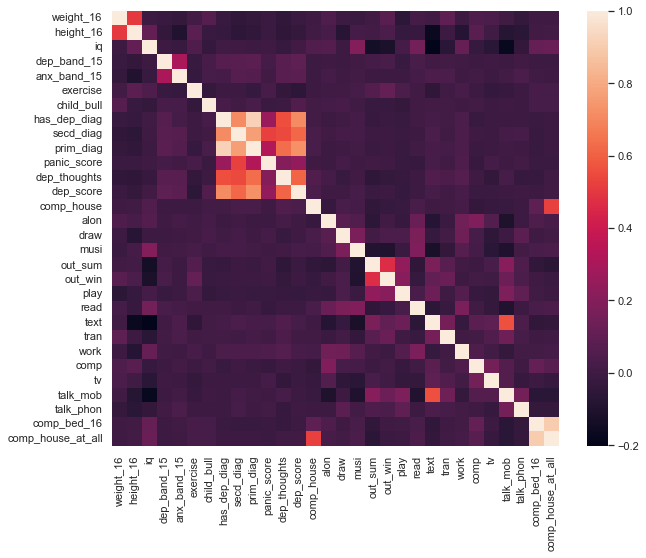

In [3]:
sns.set(rc = {'figure.figsize':(10, 8)})
sns.heatmap(data.corr())

<AxesSubplot:xlabel='level_0', ylabel='level_1'>

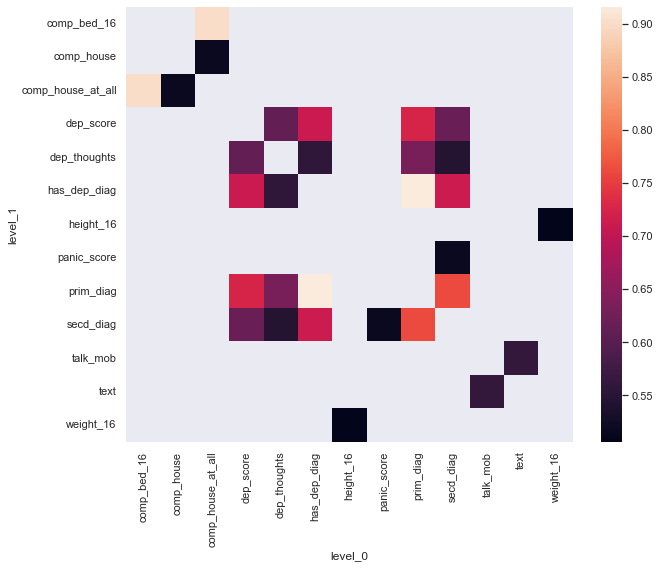

In [4]:
#getting rid of obvious correlations

s = data.corr().abs().unstack()
high = s.sort_values()

for i in high.index:
    split1 = i[0].rstrip('we k nd')
    split2 = i[1].rstrip('we k nd')
    split1 = split1.rstrip('_')
    split2 = split2.rstrip('_')
    if split1 == i[1] or split2 == i[0] or split1 == split2:
        high[i[0], i[1]] = 2
        
high = high[high >= 0.5]
high = high[high < 1]
high = high.to_frame().reset_index()
corr = pd.pivot_table(high, columns = ['level_0'], values = 0, index = ['level_1'])
sns.heatmap(corr)

<AxesSubplot:>

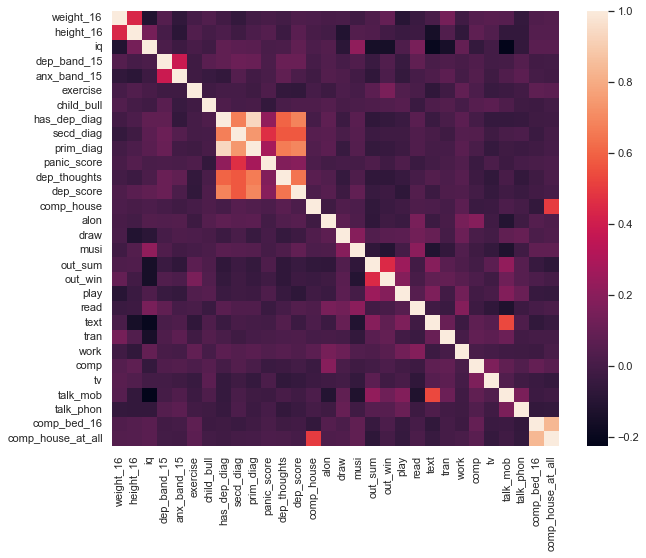

In [5]:
#target variables
dep = [x for x in data.columns if 'dep' in x or 'diag' in x or 'panic' in x]

#keeping rows with no missing data
full = data.dropna(axis = 0, how = 'any')
sns.heatmap(full.corr())

## Logistic Regression and PCA

In [6]:
#attempt at mitigating imbalanced data
lim = 8
no_dep = full.query('prim_diag <= @lim')
has_dep = full.query('prim_diag > @lim')

sample = no_dep.sample(n = 400, random_state = 1)
sample2 = has_dep.sample(n = 179, random_state = 1)

fullSample = sample.append(sample2)

C:\Users\moham\AppData\Local\Temp/ipykernel_13472/1609209872.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fullSample = sample.append(sample2)


In [7]:
#input variables
X = fullSample.drop(dep[1:-1], axis = 1)

In [8]:
#using logistic regression on X and X_pca
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

pca = PCA(0.9)

#error for dep_band_15 since its continous so i dropped it
for i in dep[1:-1]:
    y = fullSample[i]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,test_size = 0.2, random_state = 30)

    model = LogisticRegression(max_iter = 10000)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    
    X_pca = pca.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.2, random_state = 30)
    
    model2 = LogisticRegression(max_iter = 10000)
    model2.fit(X_train, y_train)
    score2 = model2.score(X_test, y_test)
    print(i, score, score2)

has_dep_diag 0.8706896551724138 0.7672413793103449
secd_diag 0.7241379310344828 0.7241379310344828
prim_diag 0.6120689655172413 0.5775862068965517
panic_score 0.9655172413793104 0.9741379310344828
dep_thoughts 0.5172413793103449 0.4482758620689655


In [9]:
pca.explained_variance_ratio_

array([0.4269844 , 0.22398378, 0.16407404, 0.07318814, 0.06014317])

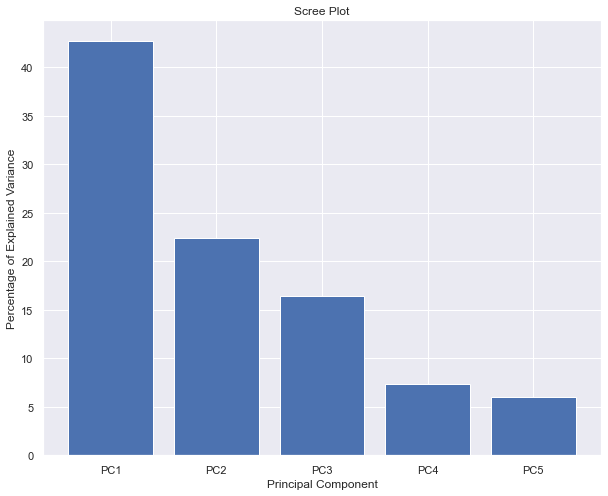

In [10]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)] 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

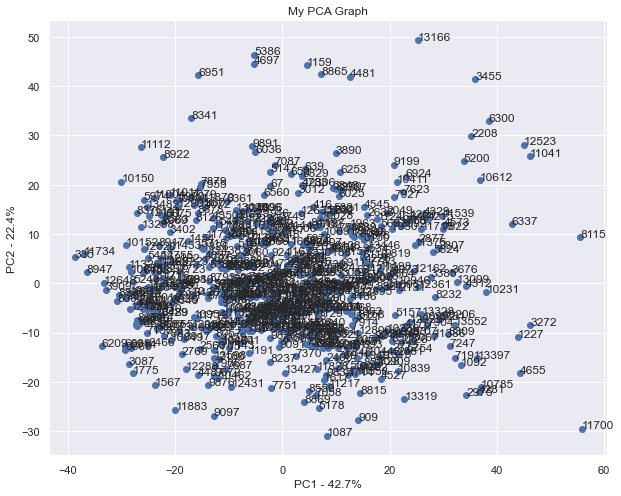

In [11]:
#??
pca_df = pd.DataFrame(X_pca, index = X.index, columns = labels)
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('My PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1])) 
for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))

In [12]:
#more pca
pca2 = PCA(n_components=2)
pca2.fit_transform(X)
print(pca2.explained_variance_ratio_)

[0.4269844  0.22398378]


original shape:    (579, 25)
transformed shape: (579, 2)


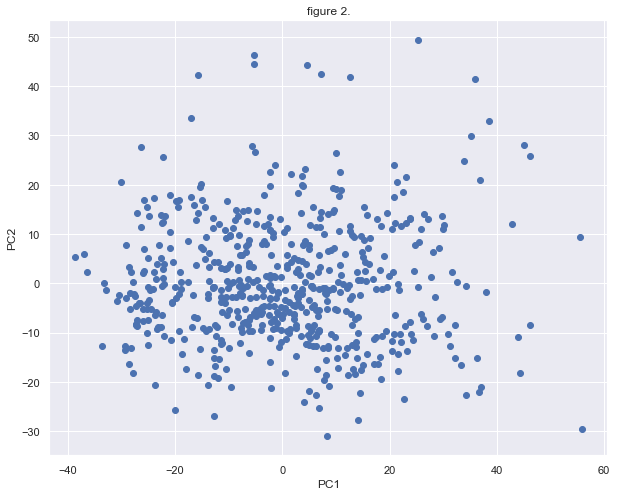

In [13]:
X_pca = pca2.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=1)
#for sample in pca2.index:
 #   plt.annotate(sample, (pca2.PC1.loc[sample], pca2.PC2.loc[sample]))
plt.title("figure 2.")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('auto');


## K-Mean

In [14]:
from sklearn.cluster import KMeans

In [15]:
def plot_k_means(X, cluster_assignments, centroid_locations):
    plt.axis('auto')
    plt.viridis()
    plt.scatter(X[:, 0], X[:, 1], s=20, c=cluster_assignments, alpha=0.9)
    plt.scatter(centroid_locations[:, 0], centroid_locations[:, 1], s=200, marker='X', c=range(K), edgecolors='k')
    plt.title("figure 3.")
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()



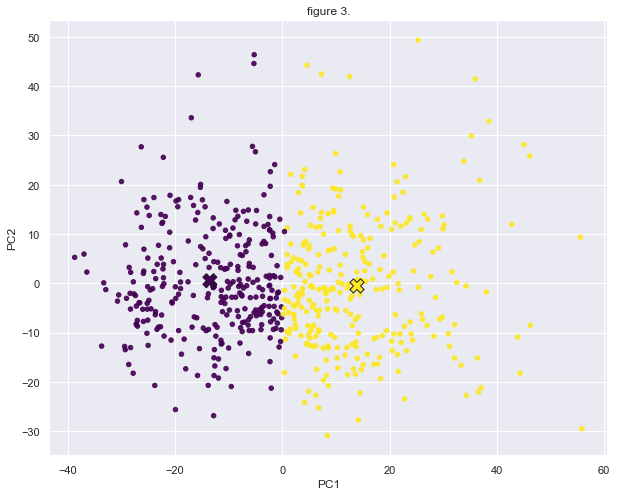

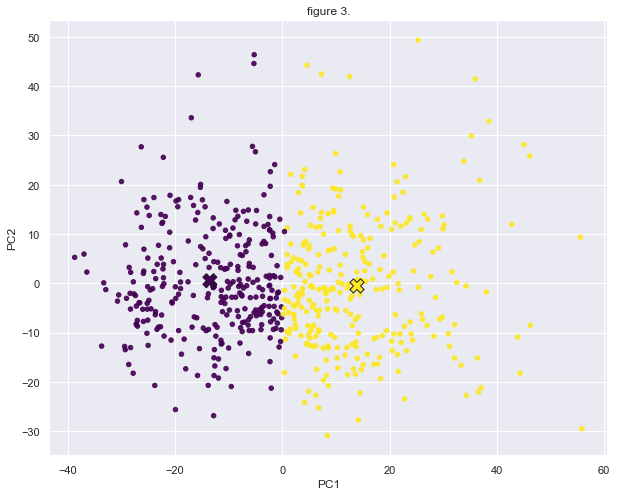

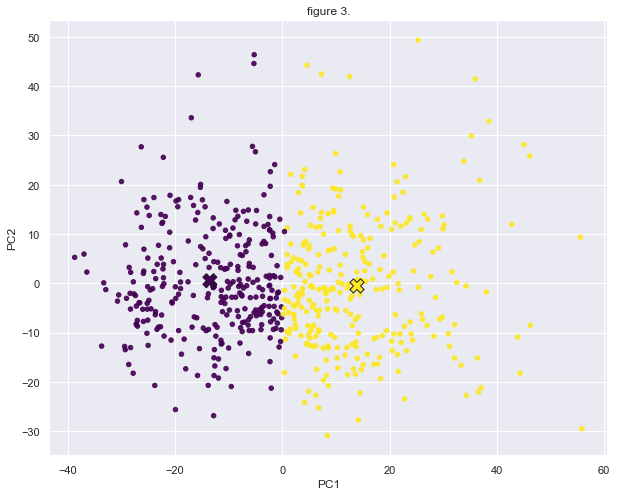

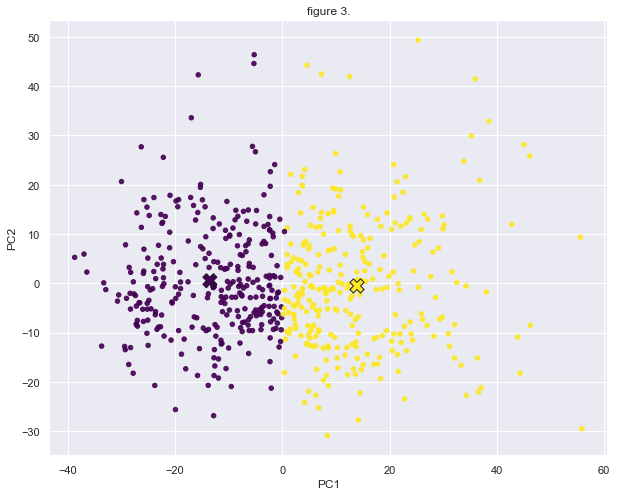

In [16]:
K = 2
kmeans = KMeans(K, init='random').fit(X_pca)
cluster_assignments = kmeans.predict(X_pca)
centroid_locations = kmeans.cluster_centers_
plot_k_means(X_pca, cluster_assignments, centroid_locations)

kmeans1 = KMeans(K).fit(X_pca)
cluster_assignments1 = kmeans1.predict(X_pca)
centroid_locations1 = kmeans1.cluster_centers_
plot_k_means(X_pca, cluster_assignments1, centroid_locations1)

kmeans2 = KMeans(K, init='random', max_iter = 2000).fit(X_pca)
cluster_assignments2 = kmeans2.predict(X_pca)
centroid_locations2 = kmeans2.cluster_centers_
plot_k_means(X_pca, cluster_assignments2, centroid_locations2)

kmeans3 = KMeans(K, init='random', n_init = 200).fit(X_pca)
cluster_assignments3 = kmeans3.predict(X_pca)
centroid_locations3 = kmeans3.cluster_centers_
plot_k_means(X_pca, cluster_assignments3, centroid_locations2)

## Gaussian Mixture Model

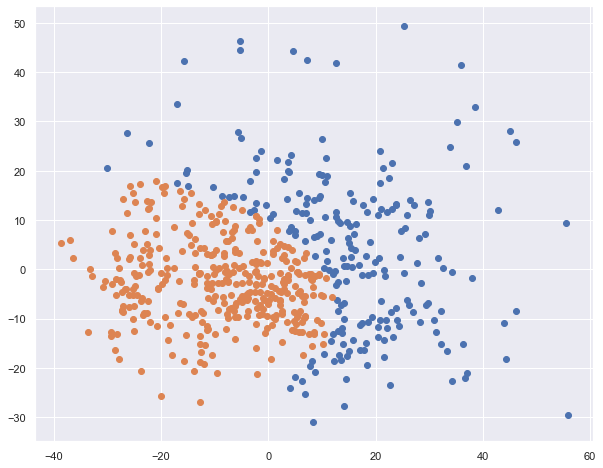

In [17]:
# gaussian mixture clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture

X = X_pca
model = GaussianMixture(n_components=2)
model.fit(X)
yhat = model.predict(X)
clusters = unique(yhat)
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.show()

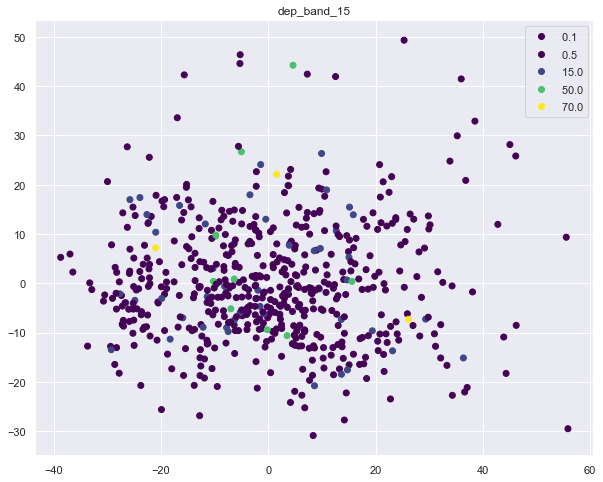

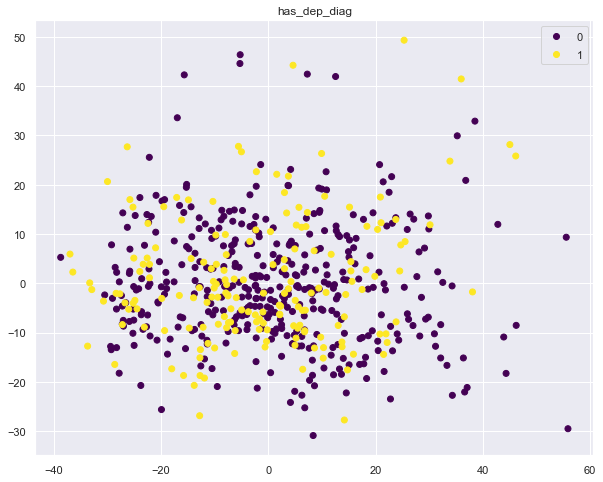

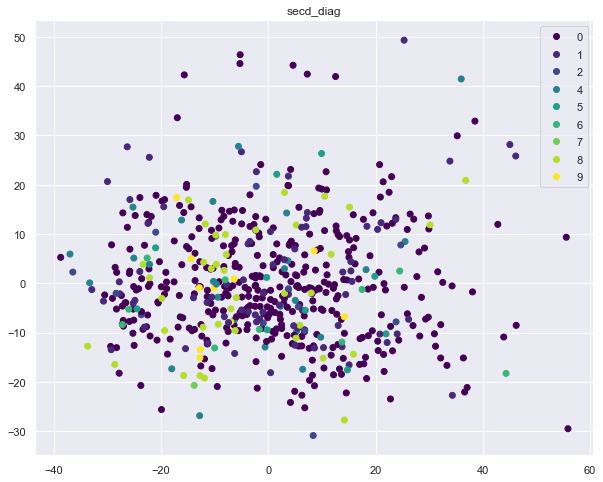

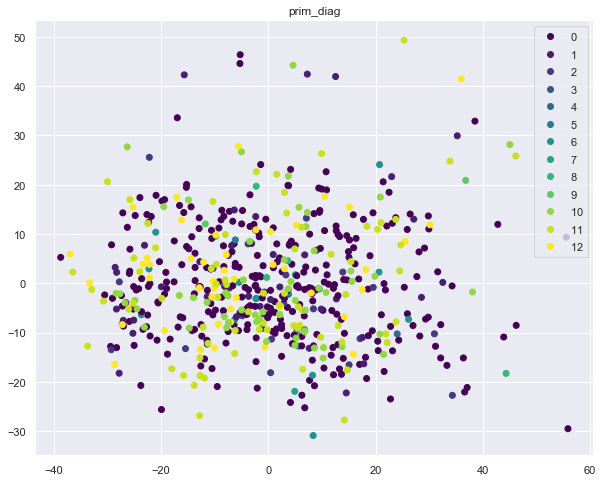

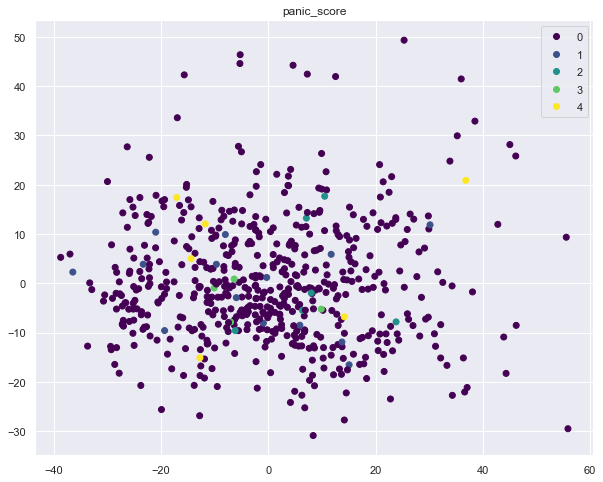

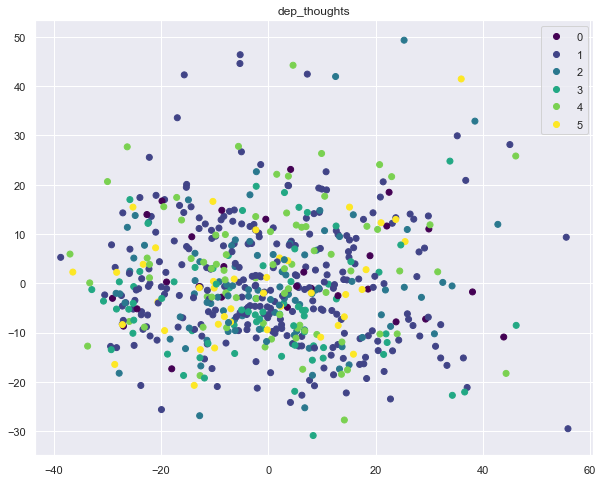

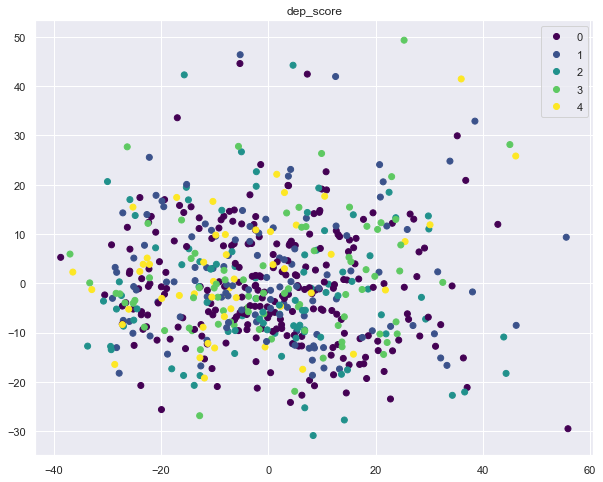

In [18]:
#comparing to data split on target variables

for i in dep:
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=1, c = fullSample[i], cmap = 'viridis')
    plt.legend(*scatter.legend_elements())
    plt.title(i)
    plt.show()

array([[<AxesSubplot:title={'center':'weight_16'}>,
        <AxesSubplot:title={'center':'height_16'}>,
        <AxesSubplot:title={'center':'iq'}>,
        <AxesSubplot:title={'center':'dep_band_15'}>,
        <AxesSubplot:title={'center':'anx_band_15'}>],
       [<AxesSubplot:title={'center':'exercise'}>,
        <AxesSubplot:title={'center':'child_bull'}>,
        <AxesSubplot:title={'center':'has_dep_diag'}>,
        <AxesSubplot:title={'center':'secd_diag'}>,
        <AxesSubplot:title={'center':'prim_diag'}>],
       [<AxesSubplot:title={'center':'panic_score'}>,
        <AxesSubplot:title={'center':'dep_thoughts'}>,
        <AxesSubplot:title={'center':'dep_score'}>,
        <AxesSubplot:title={'center':'comp_house'}>,
        <AxesSubplot:title={'center':'alon'}>],
       [<AxesSubplot:title={'center':'draw'}>,
        <AxesSubplot:title={'center':'musi'}>,
        <AxesSubplot:title={'center':'out_sum'}>,
        <AxesSubplot:title={'center':'out_win'}>,
        <AxesSubplot:t

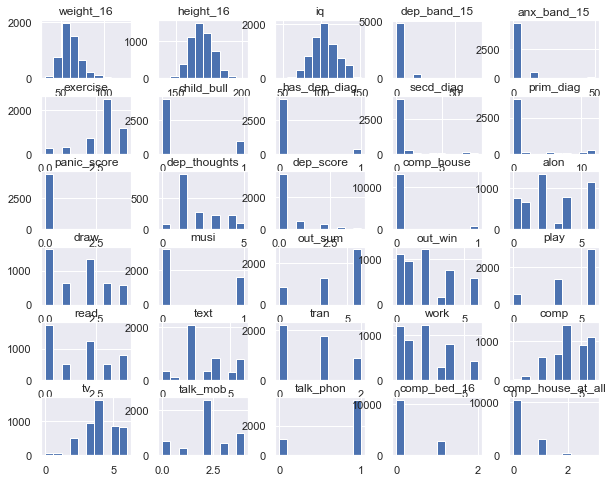

In [19]:
data.hist()

In [20]:
data.describe()

,weight_16,height_16,iq,dep_band_15,anx_band_15,exercise,child_bull,has_dep_diag,secd_diag,prim_diag,...,read,text,tran,work,comp,tv,talk_mob,talk_phon,comp_bed_16,comp_house_at_all
count,5351.000000,5364.000000,7288.000000,5299.000000,5303.000000,4971.000000,4989.000000,4513.000000,4513.000000,4513.000000,...,4825.000000,4824.000000,4854.000000,4828.000000,4829.000000,4849.000000,4830.000000,4834.000000,13734.000000,13734.000000
mean,61.720509,169.286372,103.672201,2.348764,4.104620,2.830819,0.183003,0.086195,0.417682,1.301573,...,1.597513,3.097844,0.724351,2.049503,4.162352,4.004331,2.190476,0.770583,0.221421,0.273336
std,12.003745,8.533072,16.682292,7.751135,7.492028,1.019006,0.386707,0.280684,1.514679,3.200335,...,1.472831,1.756350,0.747436,1.809739,1.420841,1.352856,1.203705,0.420501,0.436423,0.507563
min,32.300000,139.512169,45.000000,0.100000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,53.785885,163.317270,92.000000,0.100000,0.500000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,0.000000,0.000000,3.000000,3.000000,2.000000,1.000000,0.000000,0.000000
50%,59.890308,168.875015,103.000000,0.500000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,1.000000,2.000000,4.000000,4.000000,2.000000,1.000000,0.000000,0.000000
75%,67.309938,175.171323,115.000000,0.500000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,4.000000,1.000000,4.000000,5.000000,5.000000,3.000000,1.000000,0.000000,0.000000
max,126.029499,201.519622,152.000000,70.000000,50.000000,4.000000,1.000000,1.000000,9.000000,12.000000,...,4.000000,6.000000,2.000000,6.000000,6.000000,6.000000,4.000000,1.000000,2.000000,3.000000


In [21]:
data.var()

weight_16            144.089901
height_16             72.813324
iq                   278.298873
dep_band_15           60.080098
anx_band_15           56.130486
exercise               1.038374
child_bull             0.149543
has_dep_diag           0.078783
secd_diag              2.294253
prim_diag             10.242145
panic_score            0.102964
dep_thoughts           1.761504
dep_score              0.861412
comp_house             0.049223
alon                   4.498926
draw                   1.914353
musi                   0.222176
out_sum                5.272215
out_win                3.724372
play                   4.280122
read                   2.169231
text                   3.084764
tran                   0.558661
work                   3.275154
comp                   2.018789
tv                     1.830221
talk_mob               1.448905
talk_phon              0.176821
comp_bed_16            0.190465
comp_house_at_all      0.257620
dtype: float64

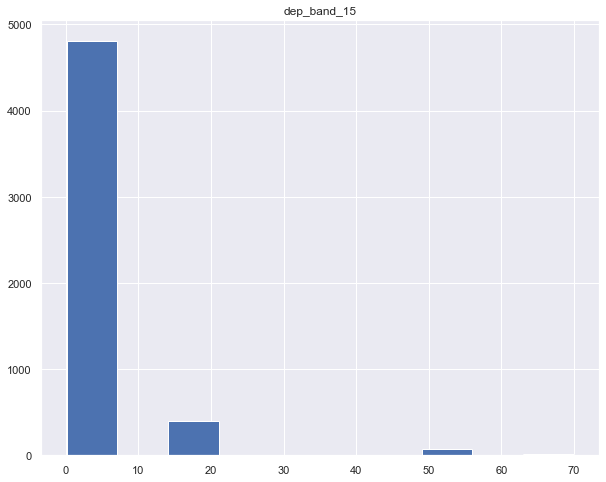

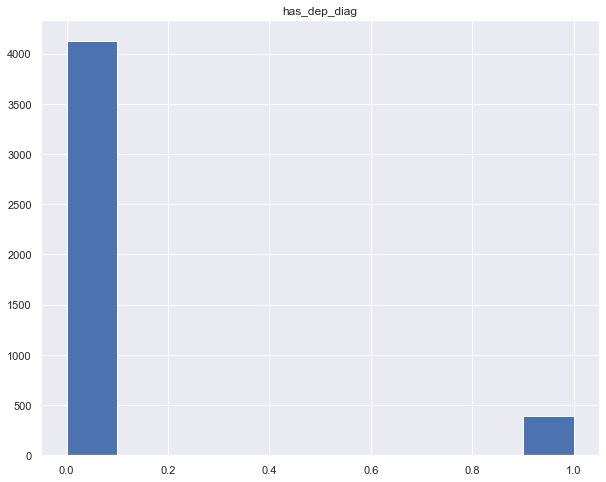

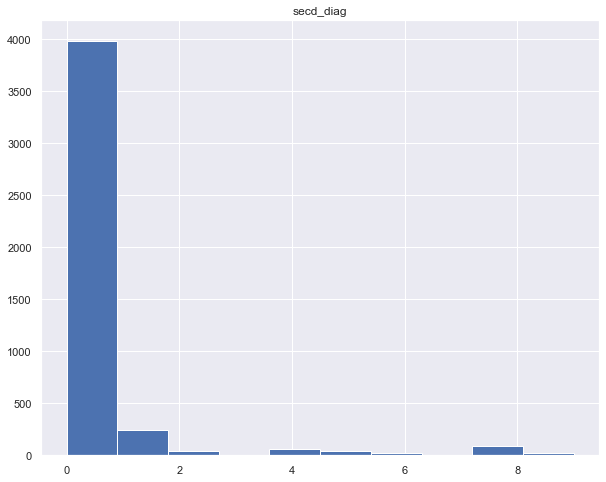

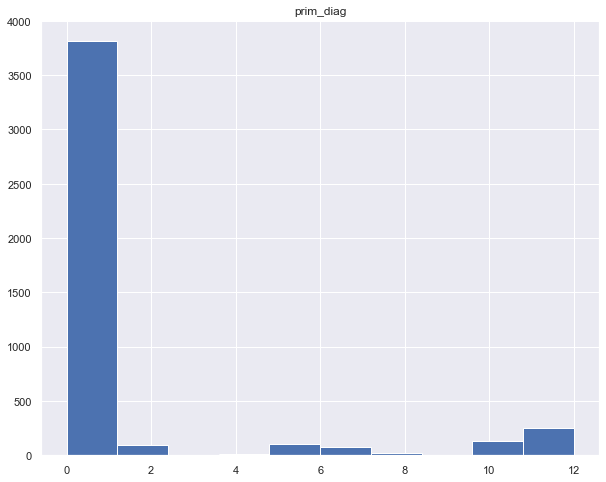

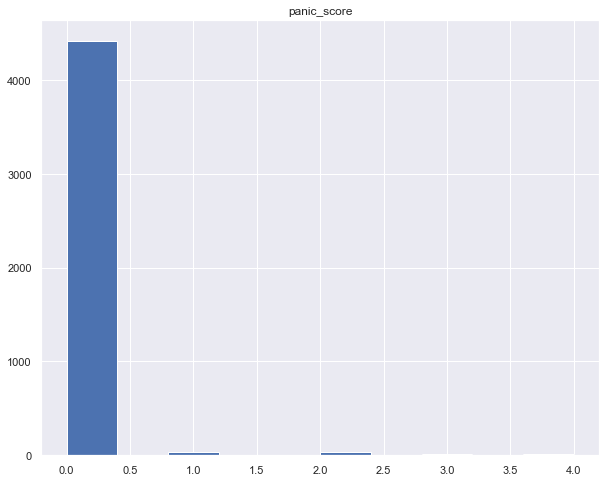

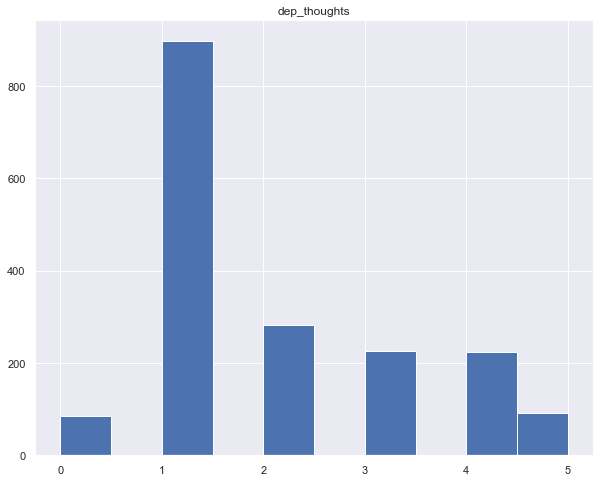

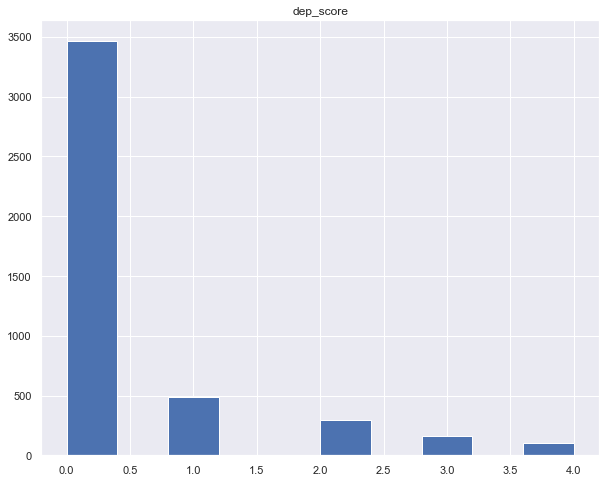

In [36]:
for i in dep:
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.hist(data[i])
    plt.title(i)

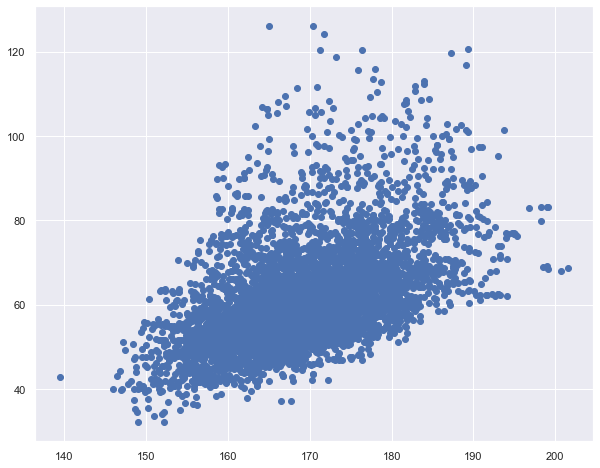

In [41]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(data['height_16'], data['weight_16'])
